In [ ]:
'''In this project, transfer learning using the pretrained VGG-19 network for Facial Expression Eecognition (FER) has been performed, using
4 datasets namely CK+, KDEF, JAFFE and a subset of FER-2013. For various processings on the sample images, use utilized the OpenCV library's functions.
The images are read, resized, histogram equalized, and augmented by random rotations and translations using these fuctions. Images were normalized
before feeding to the network for training. A 80-20 train-test split was applied and only the training images augmented and appended to the original
training set. The network's classifier was chaged according to the problem in hand, and prior layers were frozen. The training was performed using the
Adam optimizer with a learning rate of 0.0001 (10e-4) and model checkpoint was added to retain the best weights of the model. Training was conducted
for 20 epochs and batch size of 64 was used. Training curves, confusion matrix and classification report are provided at the end of each training.'''

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
# Histogram equlization helps improve the contrast of image. Real world data may have poor contrast.

# Define Histogram Equalization Function

def hist_eq(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (256, 256))

    b, g, r = cv2.split(image)

    # Apply histogram equalization to each channel
    r_eq = cv2.equalizeHist(r)
    g_eq = cv2.equalizeHist(g)
    b_eq = cv2.equalizeHist(b)
            
    # Merge the equalized channels back
    image = cv2.merge([b_eq, g_eq, r_eq])

    return image

# Data augmentation functions

def rotate_image(image):

    # Random rotation
    rows, cols, _ = image.shape
    angle = np.random.uniform(-5, 5)  # Random angle between -5 and 5 degrees
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    image_rotated = cv2.warpAffine(image, matrix, (cols, rows))

    return image_rotated

def translate_image(image):
    # Random translation between -5 to 5
    rows, cols, _ = image.shape
    tx = np.random.randint(-5, 5)
    ty = np.random.randint(-5, 5)
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    image_translated = cv2.warpAffine(image, translation_matrix, (cols, rows))

    return image_translated

In [15]:
# Load the images paths and emotion labels into a dataframe

jaffe_dir = "/kaggle/input/jaffe-dataset/jaffe/"

image_path = []
labels = []
emotion_labels = {
    "ANG": 0, "DIS": 1, "FEA": 2, "HAP": 3, "NEU": 4, "SAD": 5, "SUR": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(jaffe_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
jaffe_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
jaffe_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
jaffe_df = pd.concat([jaffe_emotion_df, jaffe_path_df], axis=1)

Text(0.5, 1.0, 'Translated, then Rotated')

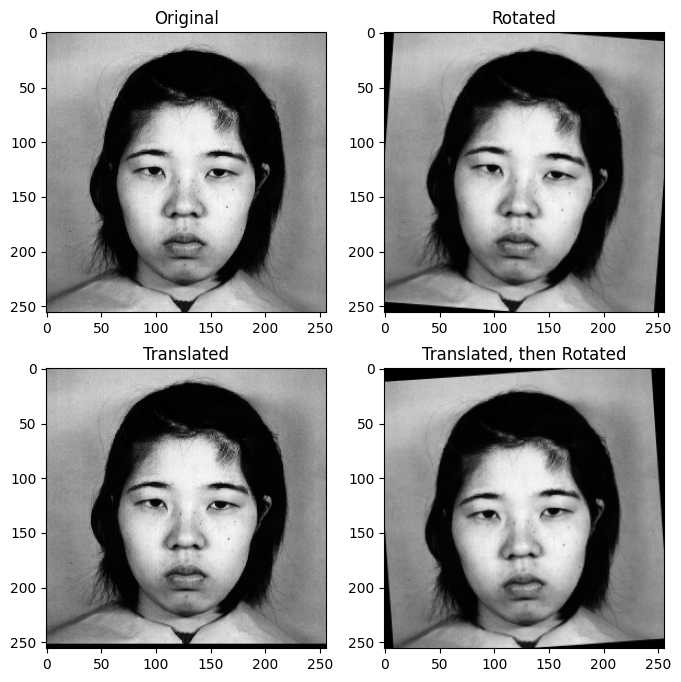

In [20]:
# Visualization of augmented images

img_path = jaffe_df.Path[0]
img = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
imgplot = plt.imshow(img)
plt.title('Original')
plt.subplot(2,2,2)
imgplot = plt.imshow(rotate_image(img))
plt.title('Rotated')
plt.subplot(2,2,3)
imgplot = plt.imshow(translate_image(img))
plt.title('Translated')
plt.subplot(2,2,4)
imgplot = plt.imshow(rotate_image(translate_image(img)))
plt.title('Translated, then Rotated')

In [53]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(jaffe_df, test_size = 0.2, random_state = 42)

In [54]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [55]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_test.append(image) # Append to train set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [56]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram as before
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [58]:
# Load pre-trained VGG16 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_jaffe_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=64, callbacks=[model_checkpoint])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.1541 - loss: 2.2500 - val_accuracy: 0.2326 - val_loss: 1.8988
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 0.2912 - loss: 1.8460 - val_accuracy: 0.4419 - val_loss: 1.7413
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.4833 - loss: 1.5800 - val_accuracy: 0.3953 - val_loss: 1.6502
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.6134 - loss: 1.3514 - val_accuracy: 0.4884 - val_loss: 1.3873
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.6911 - loss: 1.1396 - val_accuracy: 0.6279 - val_loss: 1.2669
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.7706 - loss: 0.9164 - val_accuracy: 0.7209 - val_loss: 1.1437
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8537 - loss: 0.7676 - val_accuracy: 0.6744 - val_loss: 0.9798
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 0.8629 - loss: 0.6594 - val_accuracy: 0.7907 - val_loss: 0

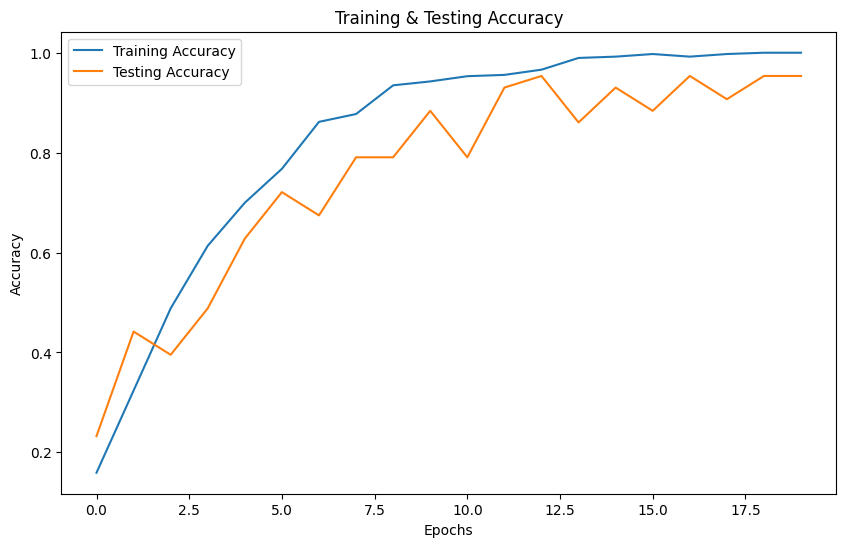

In [60]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

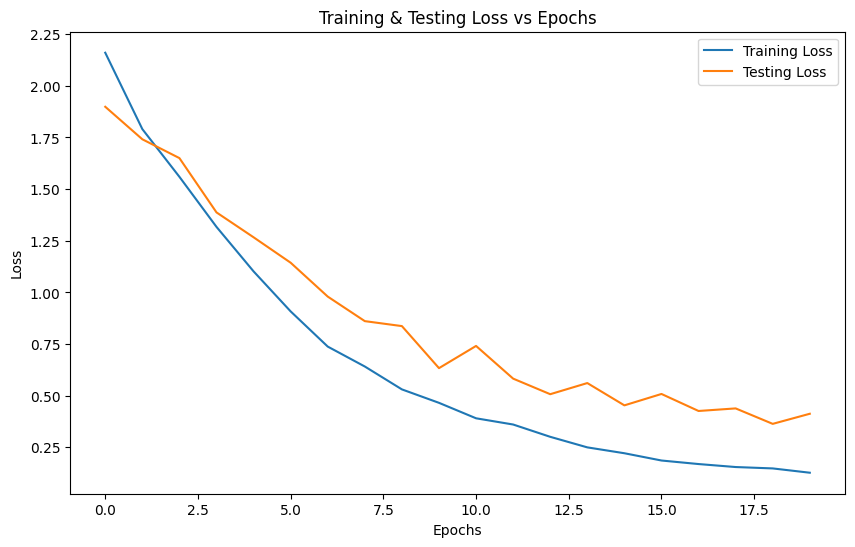

In [61]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [62]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_jaffe_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.9482 - loss: 0.4979  
Accuracy of our model on test data :  95.34883499145508 %


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


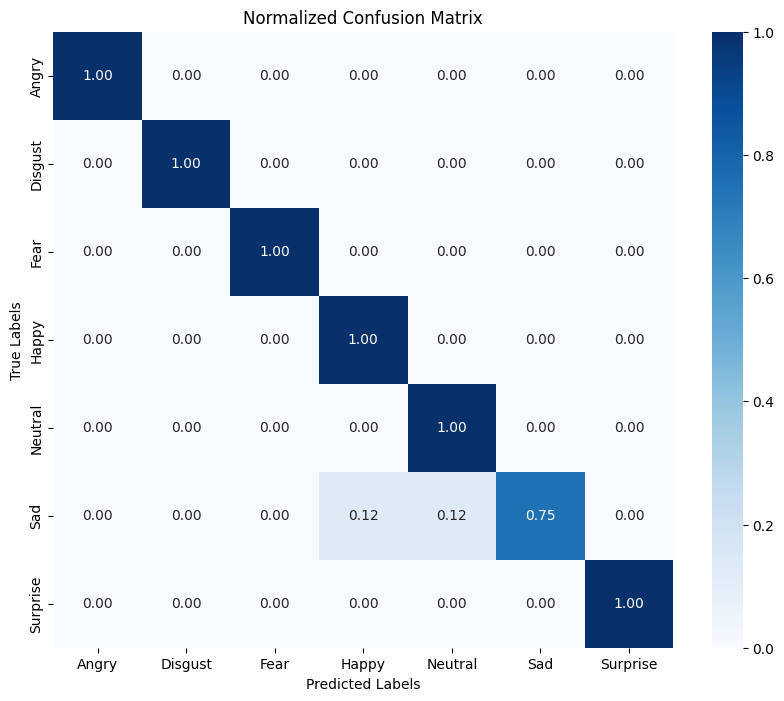

Classification Report:
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00         5
     Disgust       1.00      1.00      1.00         3
        Fear       1.00      1.00      1.00         7
       Happy       0.88      1.00      0.93         7
     Neutral       0.80      1.00      0.89         4
         Sad       1.00      0.75      0.86         8
    Surprise       1.00      1.00      1.00         9

    accuracy                           0.95        43
   macro avg       0.95      0.96      0.95        43
weighted avg       0.96      0.95      0.95        43



In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))

In [21]:
# Load the images paths and emotion labels into a dataframe

ckp_dir = "/kaggle/input/ck-dataset/"

image_path = []
labels = []
emotion_labels = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, "contempt": 4, "sadness": 5, "surprise": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(ckp_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
ckp_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
ckp_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
ckp_df = pd.concat([ckp_emotion_df, ckp_path_df], axis=1)

Text(0.5, 1.0, 'Translated, then Rotated')

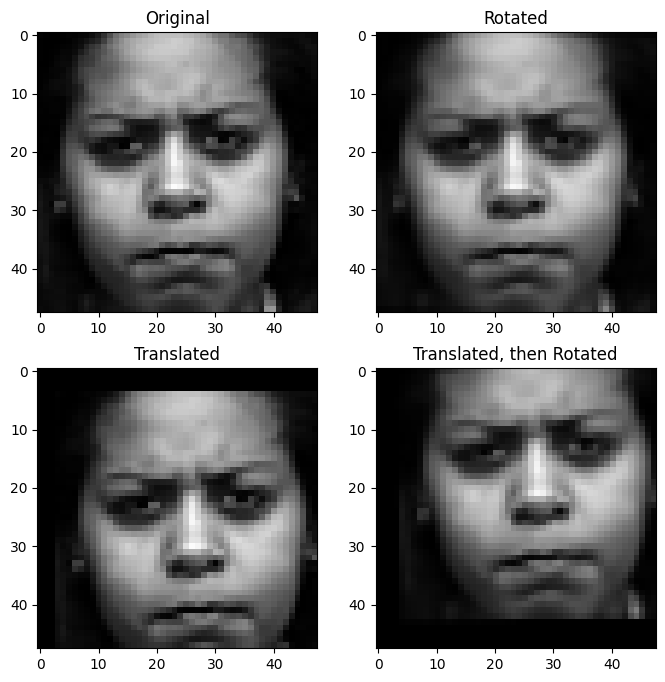

In [24]:
# Visualization of augmented images

img_path = ckp_df.Path[0]
img = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
imgplot = plt.imshow(img)
plt.title('Original')
plt.subplot(2,2,2)
imgplot = plt.imshow(rotate_image(img))
plt.title('Rotated')
plt.subplot(2,2,3)
imgplot = plt.imshow(translate_image(img))
plt.title('Translated')
plt.subplot(2,2,4)
imgplot = plt.imshow(rotate_image(translate_image(img)))
plt.title('Translated, then Rotated')

In [210]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(ckp_df, test_size = 0.2, random_state = 42)

In [217]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [218]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_test.append(image) # Append to train set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [219]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram as before
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [230]:
# Load pre-trained VGG16 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_ckp_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [231]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=64, callbacks=[model_checkpoint])

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - accuracy: 0.5163 - loss: 1.3792 - val_accuracy: 0.8782 - val_loss: 0.4597
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.9304 - loss: 0.3144 - val_accuracy: 0.9645 - val_loss: 0.2169
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.9825 - loss: 0.1398 - val_accuracy: 0.9746 - val_loss: 0.1508
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.9977 - loss: 0.0717 - val_accuracy: 0.9797 - val_loss: 0.1120
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.9939 - loss: 0.0599 - val_accuracy: 0.9898 - val_loss: 0.0788
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9996 - loss: 0.0334 - val_accuracy: 0.9797 - val_loss: 0.0846
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.9990 - loss: 0.0256 - val_accuracy: 0.9848 - val_loss: 0.0709
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accurac

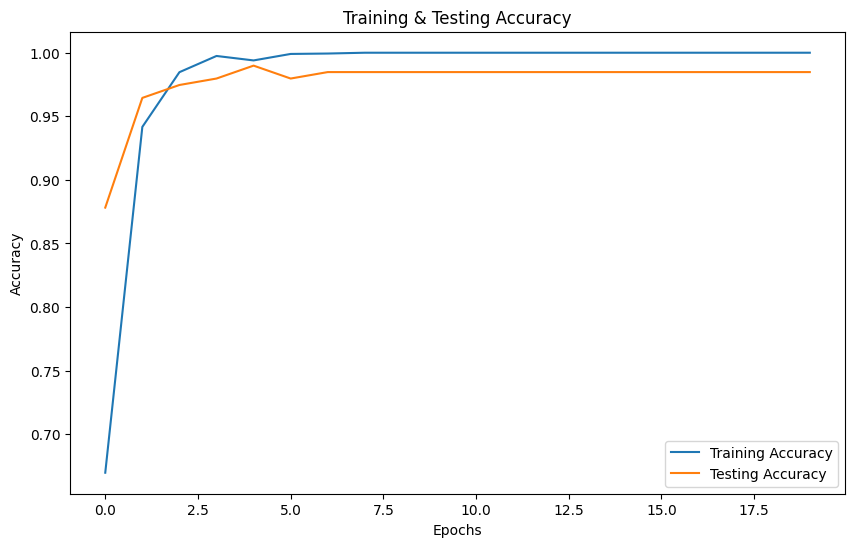

In [232]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

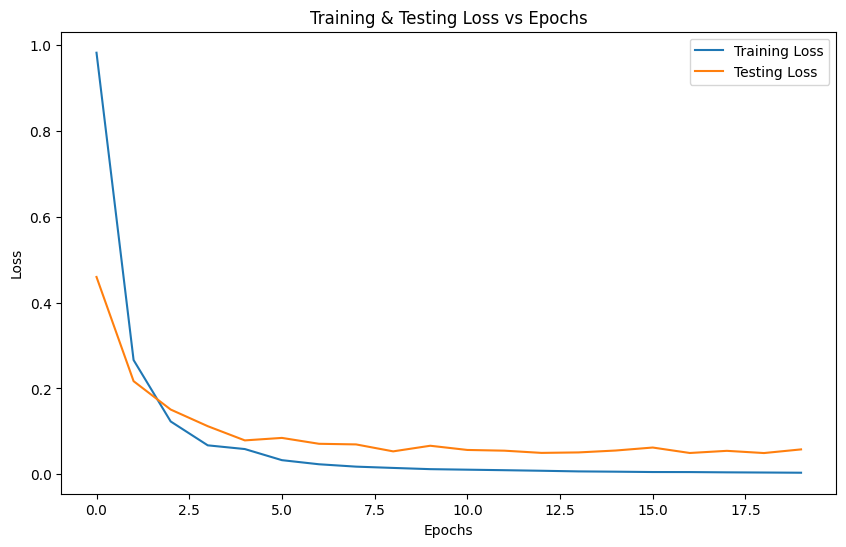

In [233]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [234]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_ckp_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9944 - loss: 0.0663
Accuracy of our model on test data :  98.9847719669342 %


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


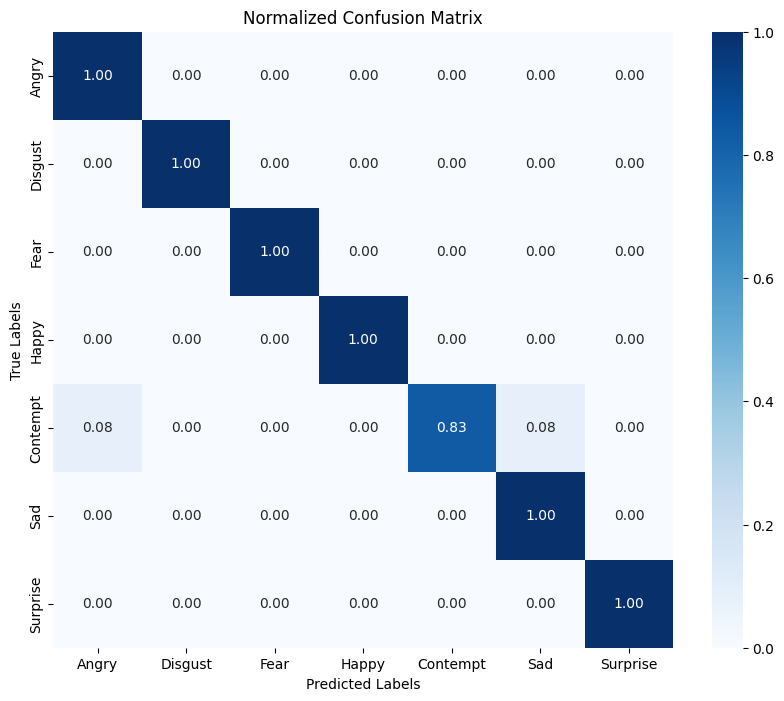

Classification Report:
              precision    recall  f1-score   support

       Angry       0.96      1.00      0.98        23
     Disgust       1.00      1.00      1.00        36
        Fear       1.00      1.00      1.00        19
       Happy       1.00      1.00      1.00        43
    Contempt       1.00      0.83      0.91        12
         Sad       0.95      1.00      0.97        19
    Surprise       1.00      1.00      1.00        45

    accuracy                           0.99       197
   macro avg       0.99      0.98      0.98       197
weighted avg       0.99      0.99      0.99       197



In [235]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Contempt', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))

In [26]:
# Load the images paths and emotion labels into a dataframe

kdef_dir = "/kaggle/input/testtt/"

image_path = []
labels = []
emotion_labels = {
    "angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(kdef_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
kdef_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
kdef_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
kdef_df = pd.concat([kdef_emotion_df, kdef_path_df], axis=1)

Text(0.5, 1.0, 'Translated, then Rotated')

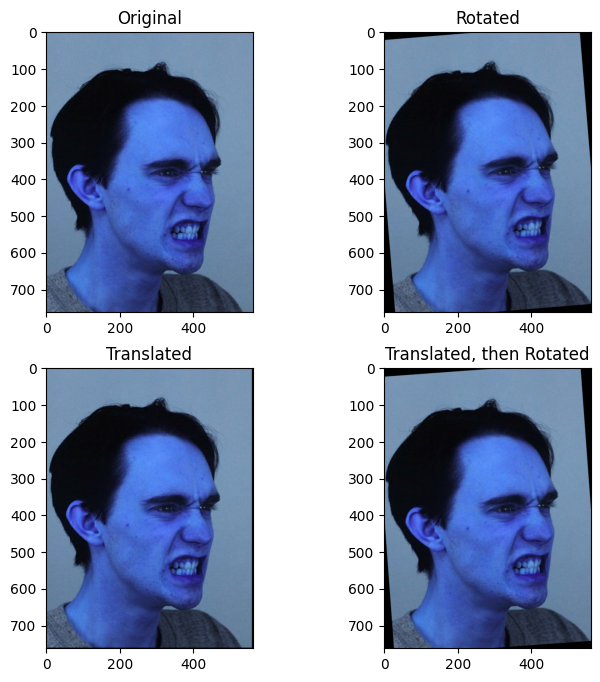

In [32]:
# Visualization of augmented images

img_path = kdef_df.Path[0]
img = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
imgplot = plt.imshow(img)
plt.title('Original')
plt.subplot(2,2,2)
imgplot = plt.imshow(rotate_image(img))
plt.title('Rotated')
plt.subplot(2,2,3)
imgplot = plt.imshow(translate_image(img))
plt.title('Translated')
plt.subplot(2,2,4)
imgplot = plt.imshow(rotate_image(translate_image(img)))
plt.title('Translated, then Rotated')

In [4]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(kdef_df, test_size = 0.2, random_state = 42)

In [38]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [39]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_test.append(image) # Append to train set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [40]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram as before
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [45]:
# Load pre-trained VGG16 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_kdef_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=64, callbacks=[model_checkpoint])

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - accuracy: 0.2351 - loss: 1.9632 - val_accuracy: 0.4847 - val_loss: 1.3703
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.5706 - loss: 1.2285 - val_accuracy: 0.6752 - val_loss: 1.0161
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.7425 - loss: 0.8374 - val_accuracy: 0.7364 - val_loss: 0.8778
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.8260 - loss: 0.6364 - val_accuracy: 0.7296 - val_loss: 0.8188
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - accuracy: 0.8501 - loss: 0.5438 - val_accuracy: 0.8027 - val_loss: 0.6443
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.9176 - loss: 0.3958 - val_accuracy: 0.8299 - val_loss: 0.5943
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.9484 - loss: 0.3244 - val_accuracy: 0.8520 - val_loss: 0.5329
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.9517 - loss: 0.2890 - val_accu

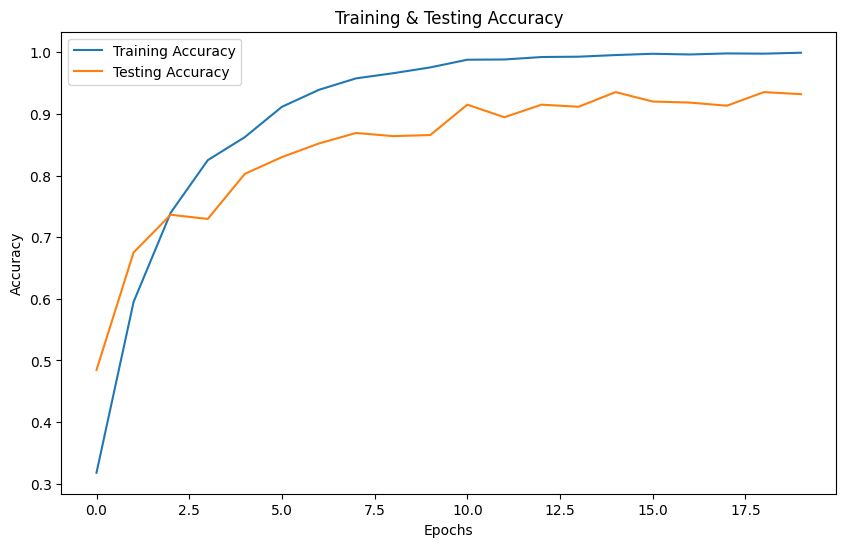

In [47]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

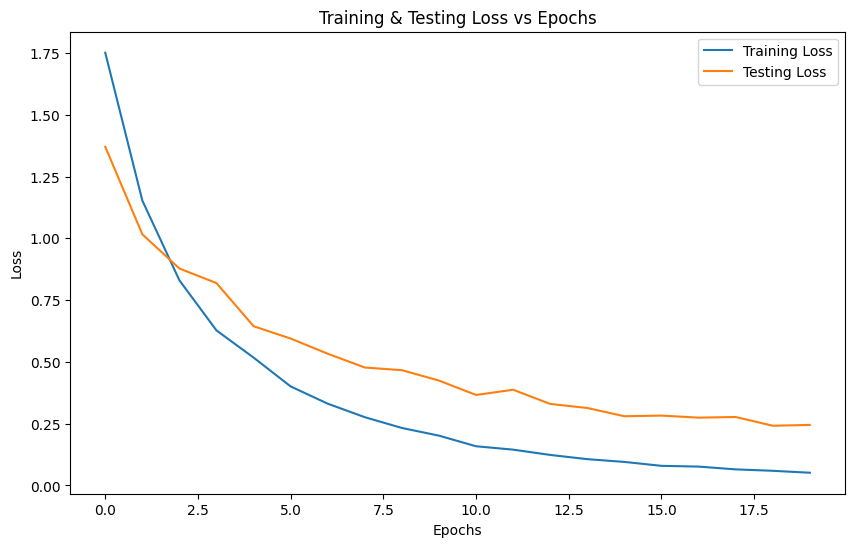

In [48]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [50]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_kdef_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9406 - loss: 0.2681
Accuracy of our model on test data :  93.53741407394409 %


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step


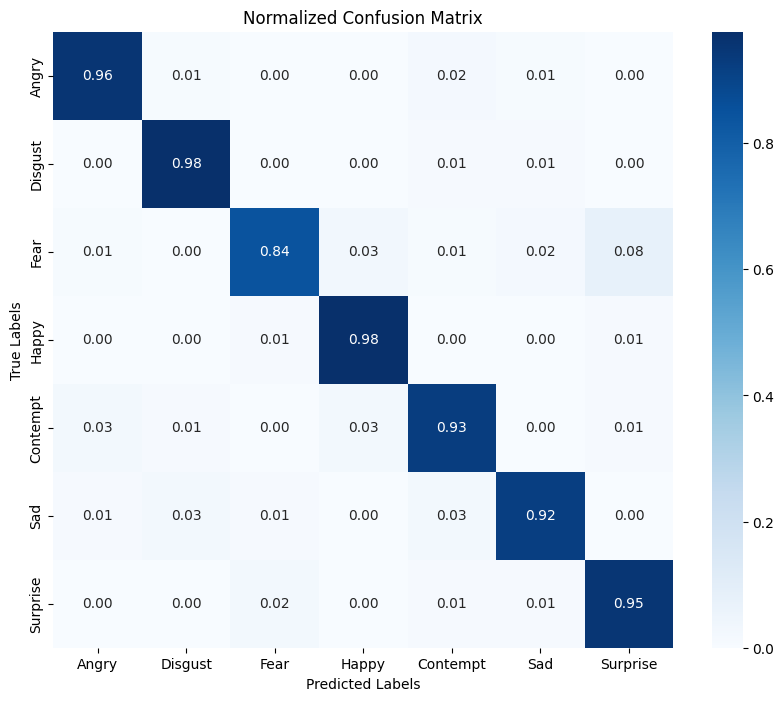

Classification Report:
              precision    recall  f1-score   support

       Angry       0.96      0.96      0.96        90
     Disgust       0.95      0.98      0.97        86
        Fear       0.95      0.84      0.89        90
       Happy       0.94      0.98      0.96        81
    Contempt       0.91      0.93      0.92        80
         Sad       0.93      0.92      0.93        77
    Surprise       0.90      0.95      0.92        84

    accuracy                           0.94       588
   macro avg       0.94      0.94      0.93       588
weighted avg       0.94      0.94      0.93       588



In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Contempt', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))

In [2]:
# Load the images paths and emotion labels into a dataframe

fer_dir = "/kaggle/input/fer-dataset/FER/"

image_path = []
labels = []
emotion_labels = {
    "Anger": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Neutral": 4, "Sad": 5, "Surprise": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(fer_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
fer_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
fer_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
fer_df = pd.concat([fer_emotion_df, fer_path_df], axis=1)

Text(0.5, 1.0, 'Translated, then Rotated')

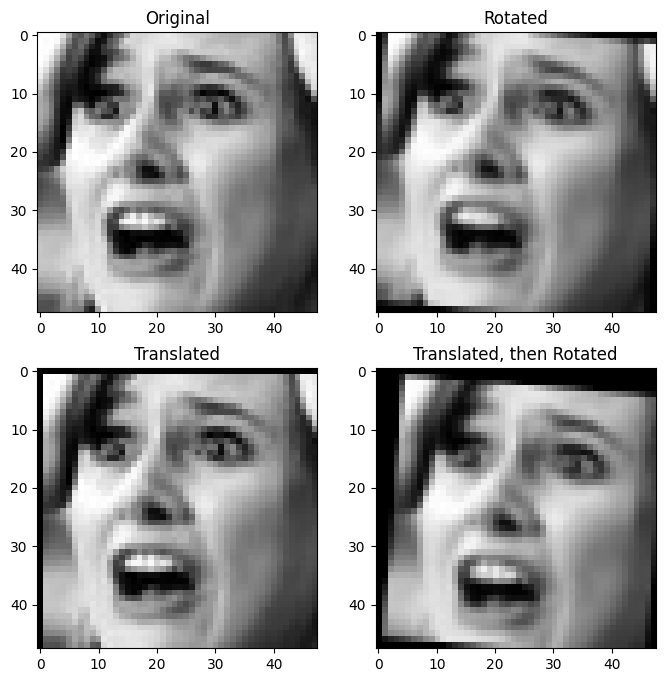

In [33]:
# Visualization of augmented images

img_path = fer_df.Path[0]
img = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
imgplot = plt.imshow(img)
plt.title('Original')
plt.subplot(2,2,2)
imgplot = plt.imshow(rotate_image(img))
plt.title('Rotated')
plt.subplot(2,2,3)
imgplot = plt.imshow(translate_image(img))
plt.title('Translated')
plt.subplot(2,2,4)
imgplot = plt.imshow(rotate_image(translate_image(img)))
plt.title('Translated, then Rotated')

In [3]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(fer_df, test_size = 0.2, random_state = 42)

In [6]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [7]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram
    X_test.append(image) # Append to train set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [8]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = hist_eq(path) # Equalize Histogram as before
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [9]:
# Load pre-trained VGG16 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_fer_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=64, callbacks=[model_checkpoint])

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 84s 294ms/step - accuracy: 0.2649 - loss: 1.8795 - val_accuracy: 0.4196 - val_loss: 1.5589
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.4570 - loss: 1.4517 - val_accuracy: 0.4517 - val_loss: 1.4372
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.5461 - loss: 1.2543 - val_accuracy: 0.4977 - val_loss: 1.3388
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.6140 - loss: 1.1021 - val_accuracy: 0.5332 - val_loss: 1.2591
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.6629 - loss: 0.9993 - val_accuracy: 0.5529 - val_loss: 1.2238
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.7035 - loss: 0.8976 - val_accuracy: 0.5837 - val_loss: 1.1470
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.7525 - loss: 0.8037 - val_accuracy: 0.5962 - val_loss: 1.1176
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.7832 - loss: 0

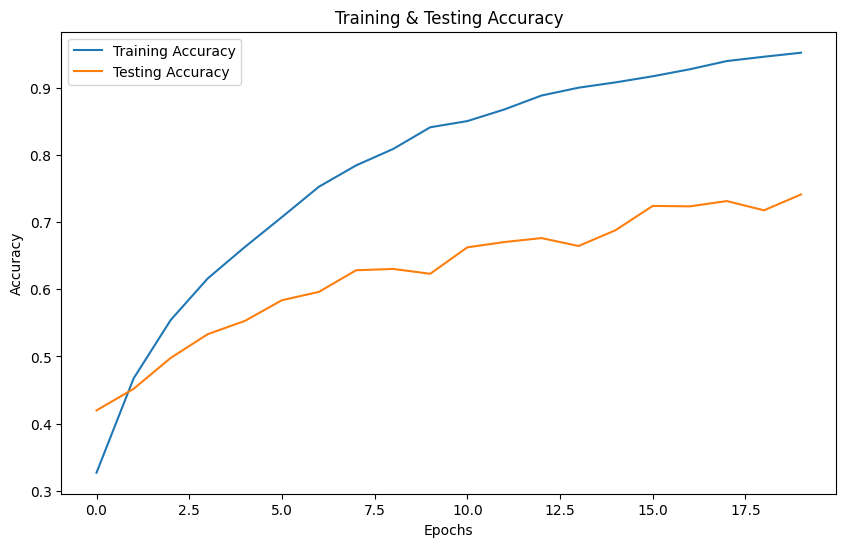

In [11]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

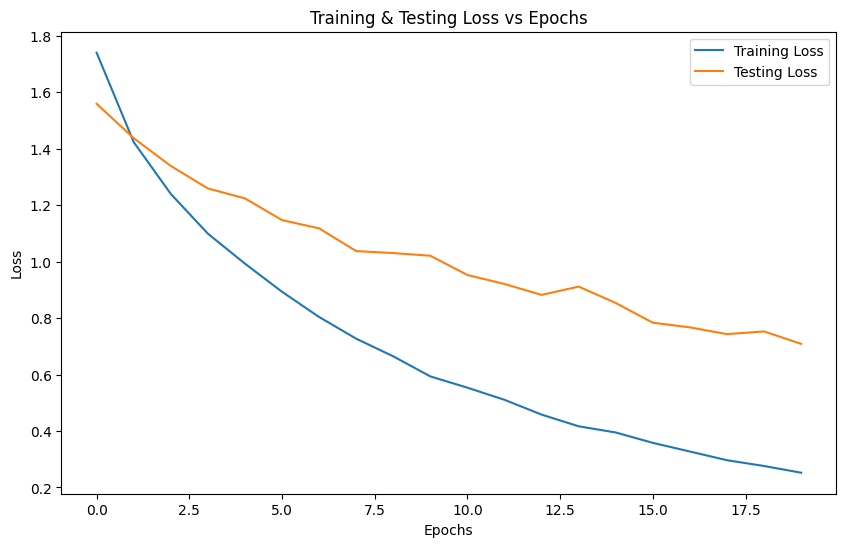

In [12]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [13]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_fer_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.7368 - loss: 0.7279
Accuracy of our model on test data :  74.13000464439392 %


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step


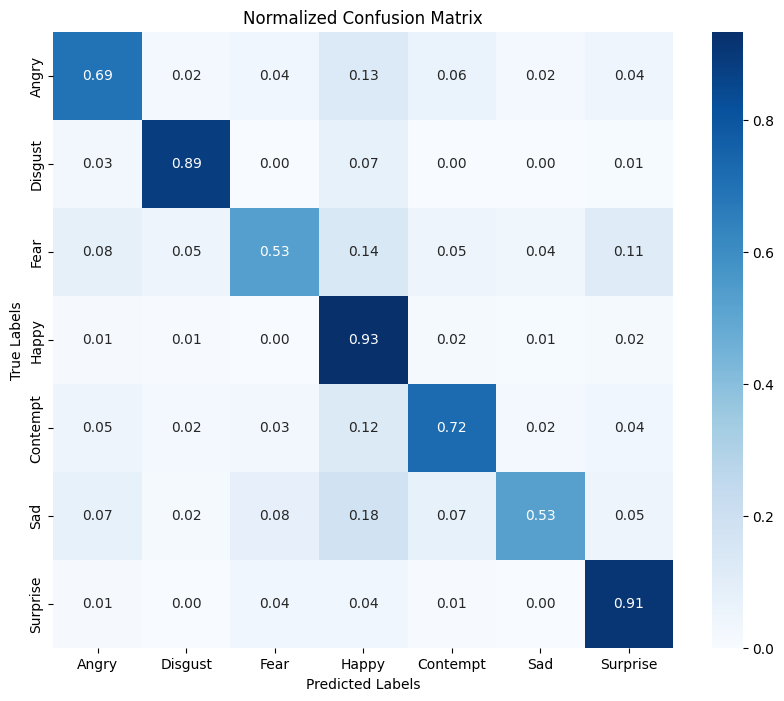

Classification Report:
              precision    recall  f1-score   support

       Angry       0.71      0.69      0.70       199
     Disgust       0.81      0.89      0.85       122
        Fear       0.74      0.53      0.62       209
       Happy       0.68      0.93      0.79       334
    Contempt       0.79      0.72      0.75       249
         Sad       0.86      0.53      0.65       240
    Surprise       0.72      0.91      0.81       170

    accuracy                           0.74      1523
   macro avg       0.76      0.74      0.74      1523
weighted avg       0.75      0.74      0.73      1523



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Contempt', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))